In [377]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

import scipy.stats as stats

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from pymorphy3 import MorphAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

,brand_id,date,receipts_count
1,178,2016-07-01,234
4,178,2016-07-02,185
7,178,2016-07-03,190
10,178,2016-07-04,196
13,178,2016-07-05,336


<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 457
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   brand_id        153 non-null    int64         
 1   date            153 non-null    datetime64[ns]
 2   receipts_count  153 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 KB


None

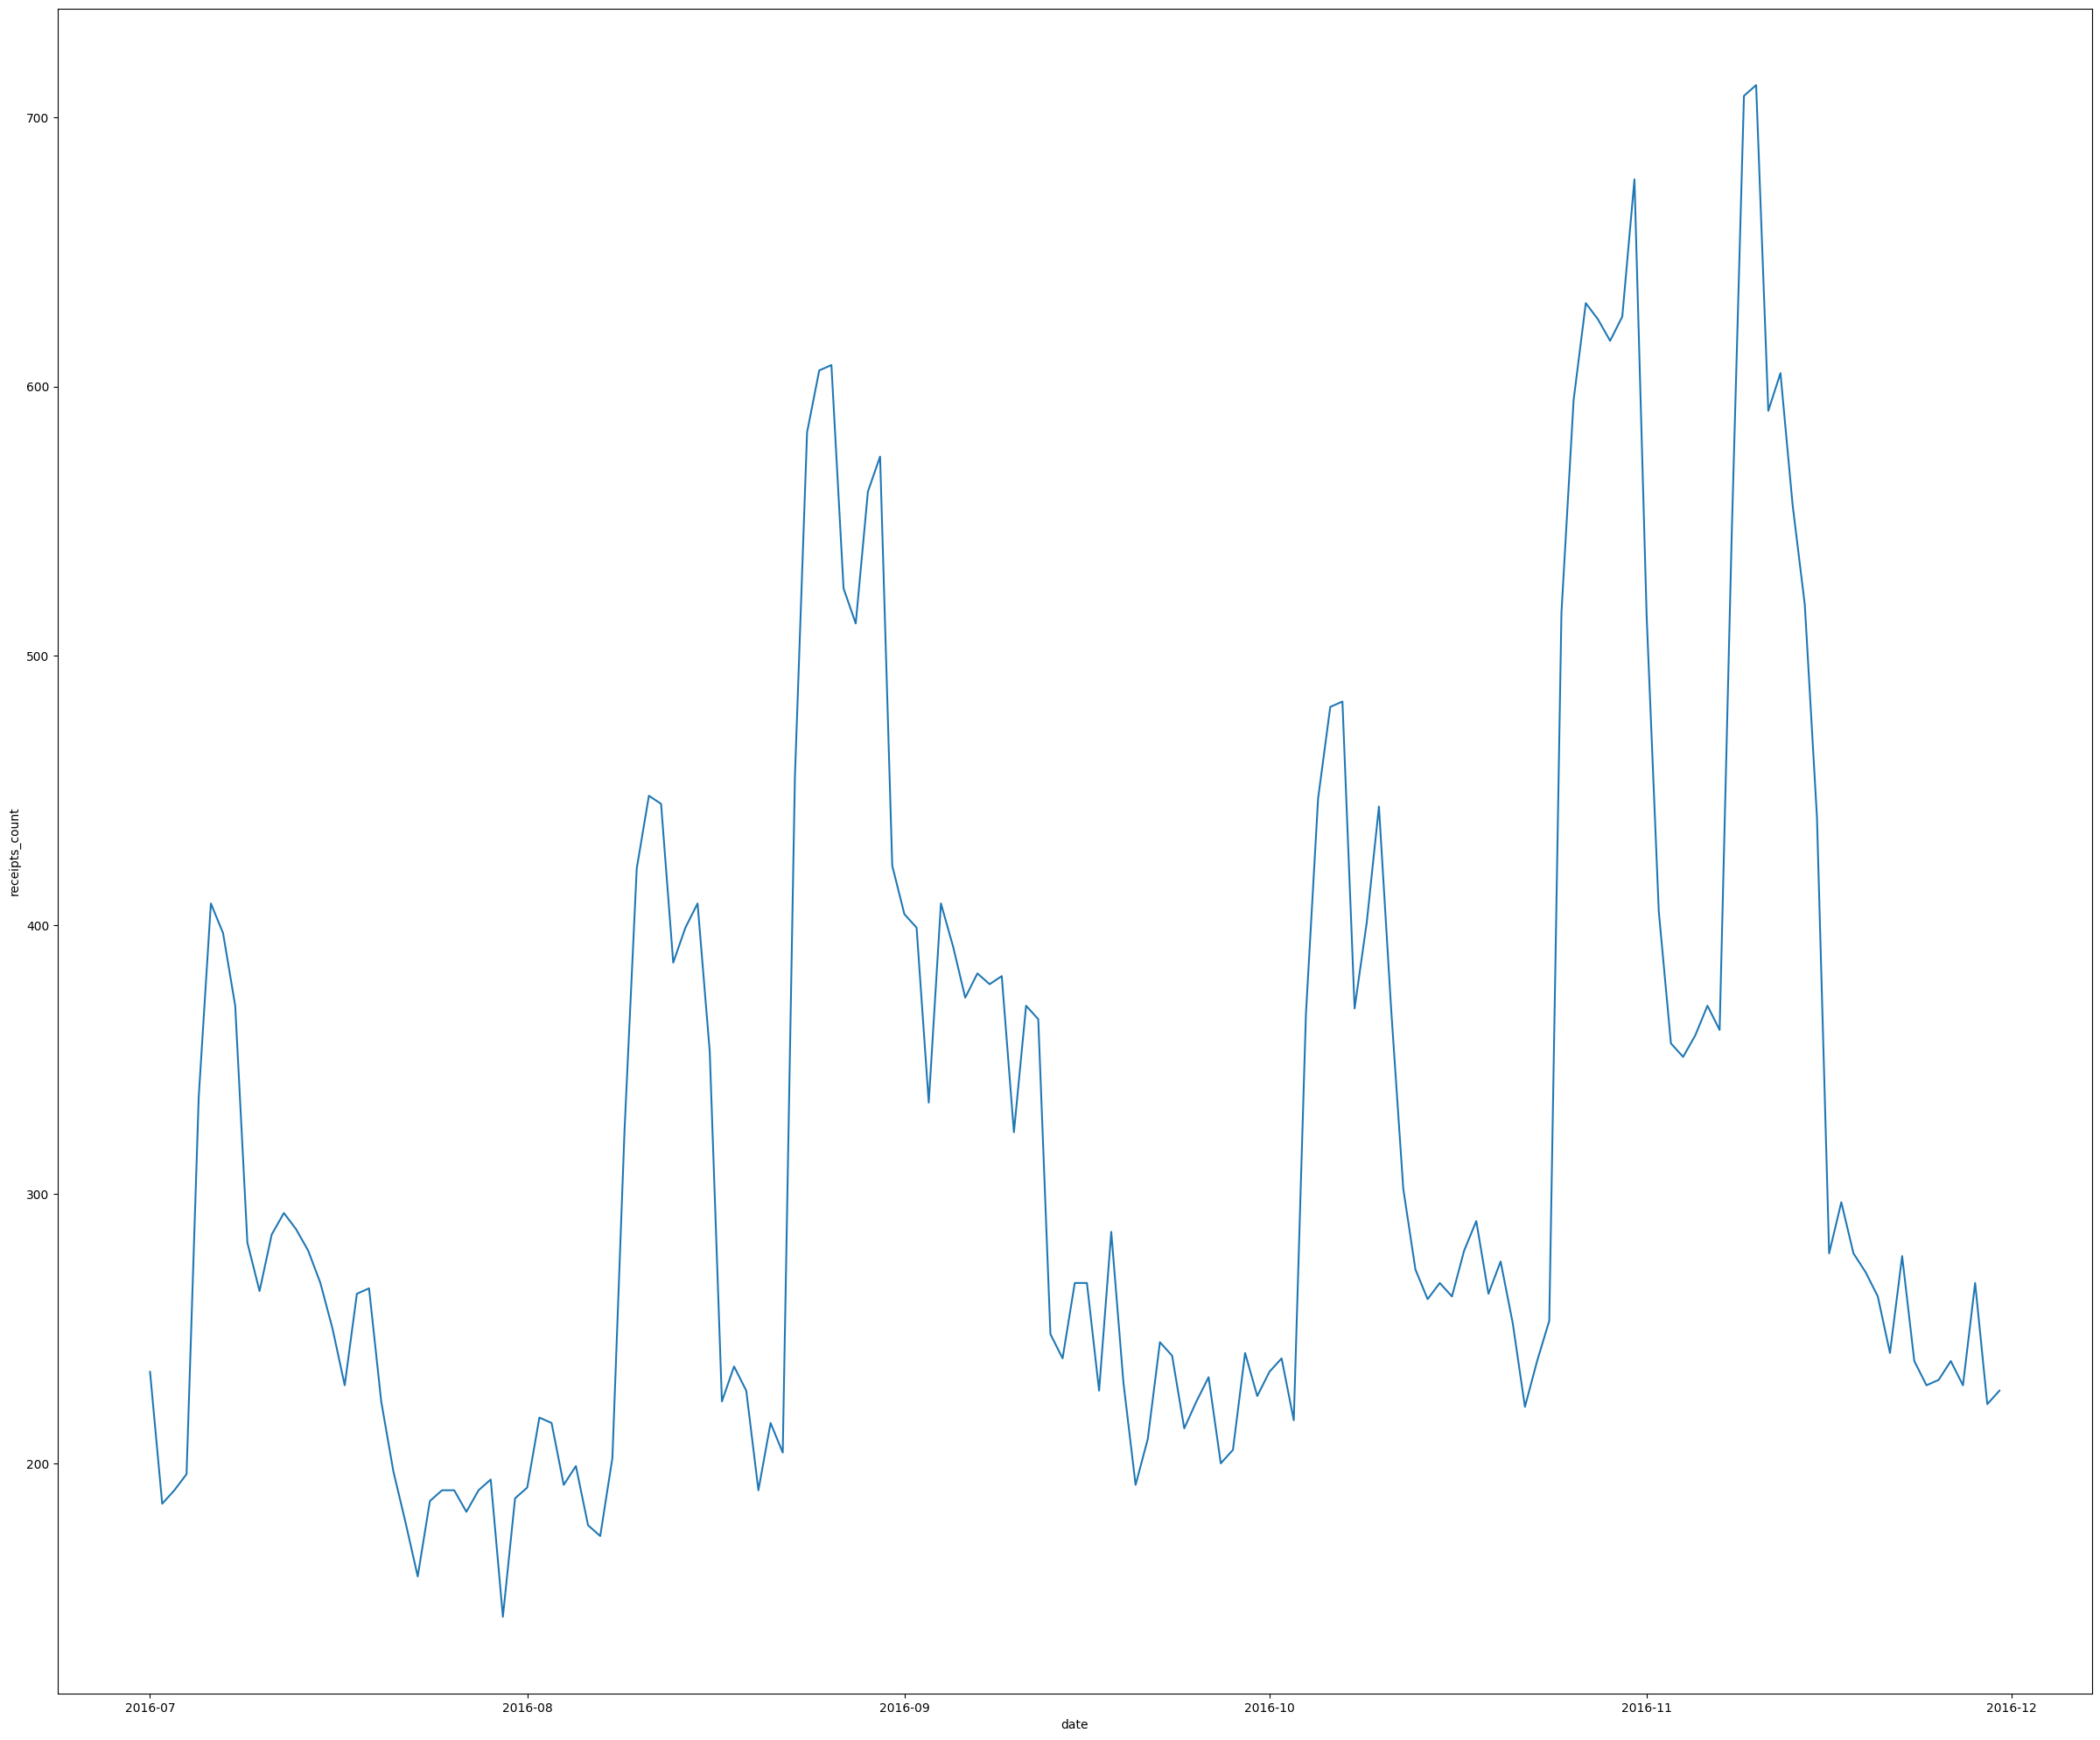

In [344]:
data_raw = pd.read_csv("data/tea_demand.csv", sep="\t", parse_dates=["date"])


data = data_raw[data_raw["brand_id"] == 178]

display(data.head())
display(data.info())

# Построим график
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 25))

barplot_sells = sns.lineplot(x=data["date"], y=data["receipts_count"])

plt.show()

----
### Спарсим нформацию по датам проведения программы Что, Где, Когда

In [345]:
date_list = []
for i in range(10):
    date_list.append(pd.read_html("https://www.toramp.com/schedule.php?id=3857")[i]['Дата'])

In [346]:
date_frame = pd.DataFrame()
for i in date_list:
    date_frame = pd.concat([date_frame, i], axis=0)
    
date_frame.rename(columns={"Дата": "date"}, inplace=True)
date_frame.head()

,date
0,19 марта 2023
1,26 марта 2023
2,2 апреля 2023
3,9 апреля 2023
4,16 апреля 2023


In [347]:
morph = MorphAnalyzer()

def date_normalize(date):
    # Словарь замены месяцев
    months = {
        "январь": "1",
        "февраль": "2",
        "март": "3",
        "апрель": "4",
        "май": "5",
        "июнь": "6",
        "июль": "7",
        "август": "8",
        "сентябрь": "9",
        "октябрь": "10",
        "ноябрь": "11",
        "декабрь": "12",
    }

    # Разрежем строку
    date = date.split(" ")
    new_date = []

    # Пройдемся по элементам списка и приведем месяц к нормальной форме добавив все в список
    for i in date:
        new_date.append(str(morph.parse(i)[0].normal_form))

    # Заменим нормальную форму на номер месяца из списка
    new_date[1] = months[new_date[1]]

    # Вернем итоговую строку для преобразования в datetime
    new_string = ".".join(str(item) for item in new_date)

    return new_string

In [348]:
date_frame["date"] = date_frame["date"].apply(date_normalize)
date_frame["date"] = pd.to_datetime(date_frame["date"])

In [349]:
programs_date = date_frame[date_frame["date"].dt.year == 2016]
programs_date

,date
0,2016-03-27
1,2016-04-03
2,2016-04-10
3,2016-04-17
4,2016-04-24
5,2016-05-15
6,2016-05-22
7,2016-05-29
8,2016-06-05
9,2016-06-19


Это интересующий нас список дат проведения программы Что, Где, Когда.

Добавим в основной фрейм признак пересечени показа рекламы и показа программы.

In [350]:
# Сопоставим даты проведения программы и даты проведения рекламных акций
data["programm_factor"] = data['date'].isin(programs_date['date'])
display(data[data["programm_factor"] == True])

,brand_id,date,receipts_count,programm_factor
259,178,2016-09-25,223,True
280,178,2016-10-02,239,True
301,178,2016-10-09,401,True
322,178,2016-10-16,262,True
343,178,2016-10-23,238,True
430,178,2016-11-21,241,True
451,178,2016-11-28,267,True


> Можно наблюдать возможную маркетинговую стратегию по проведению рекламной акции в контексте интеграции, можно сказать что с учетом накопительного эффекта реальное влияние на поведение кривой продаж должно наблюдаться в течении проведения рекламной акции, а так же с определенным нисходящим эффектом позже. Исходя из поставленной задачи, мы должны определить имело ли место влияние на кривую хотя бы в течении периода проведения, исходя из предположения, что наибольшее влияние приходится именно на этот период. Следовательно, если рекламная интеграция возымела эффект, то модельное предсказание времяного ряда должно быть ниже чем факт, а так же должны иметься выбросы по факту в последующих периодах (говорящих о том что на временной ряд влиял экзогенный фактор-наша реклама). 

---
### Проверим наличие аномалий статистически

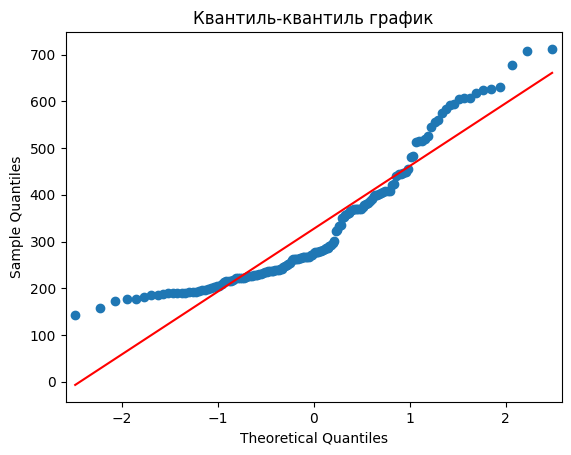

In [372]:
# Посмотрим характер распределения
sm.qqplot(data["receipts_count"], line='s')
plt.title('Квантиль-квантиль график')
plt.show()

> Можно выделить на графике несколько моменов, распределение далеко от норсвльного (что еще проверим тестом), выделяюься точки в хвостах, значение которых сильно отстают от основного распределения, как бы лежа в ли от линии укладки распределения на уровнях выше ~620 и ниже ~150, что в прочем может не являться выбросами (посмотри еще на боксплоте).

In [376]:
# Проведем тест Шапиро-Уилка
_, p = stats.shapiro(data["receipts_count"])
alpha = 0.05

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


> Собственно данные распределения не нормалино, метод z-отклоненей может дать неверные результаты. Посмотрим на диаграмму боксплот, прикинем интервал отсечения и отметим точки попавшие в него.

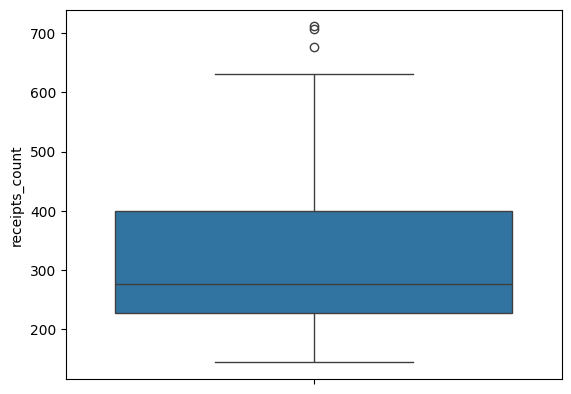

In [368]:
sns.boxplot(data["receipts_count"])
plt.show()

In [410]:
data["stats_flag"] = data["receipts_count"].apply(lambda x: 1 if x >= 635 else 0)

# Посмотрим на полученные точки
display(data[data["stats_flag"] == 1])

,brand_id,date,receipts_count,programm_factor,stats_flag
367,178,2016-10-31,677,False,1
394,178,2016-11-09,708,False,1
397,178,2016-11-10,712,False,1


In [431]:
low_bnd_st = data["date"][data["stats_flag"] == 1].dt.date.min()
up_bnd_st = (data["date"][data["stats_flag"] == 1].dt.date.max())

print(low_bnd_st)
print(up_bnd_st)


2016-10-31
2016-11-10


> Отметим, что точки распределены плотно в почти непрерывном интервале, что дает нам повод отметить весь интервал как аномальный, принимая за его границы первую и последнюю даты

TypeError: Invalid comparison between dtype=datetime64[ns] and int

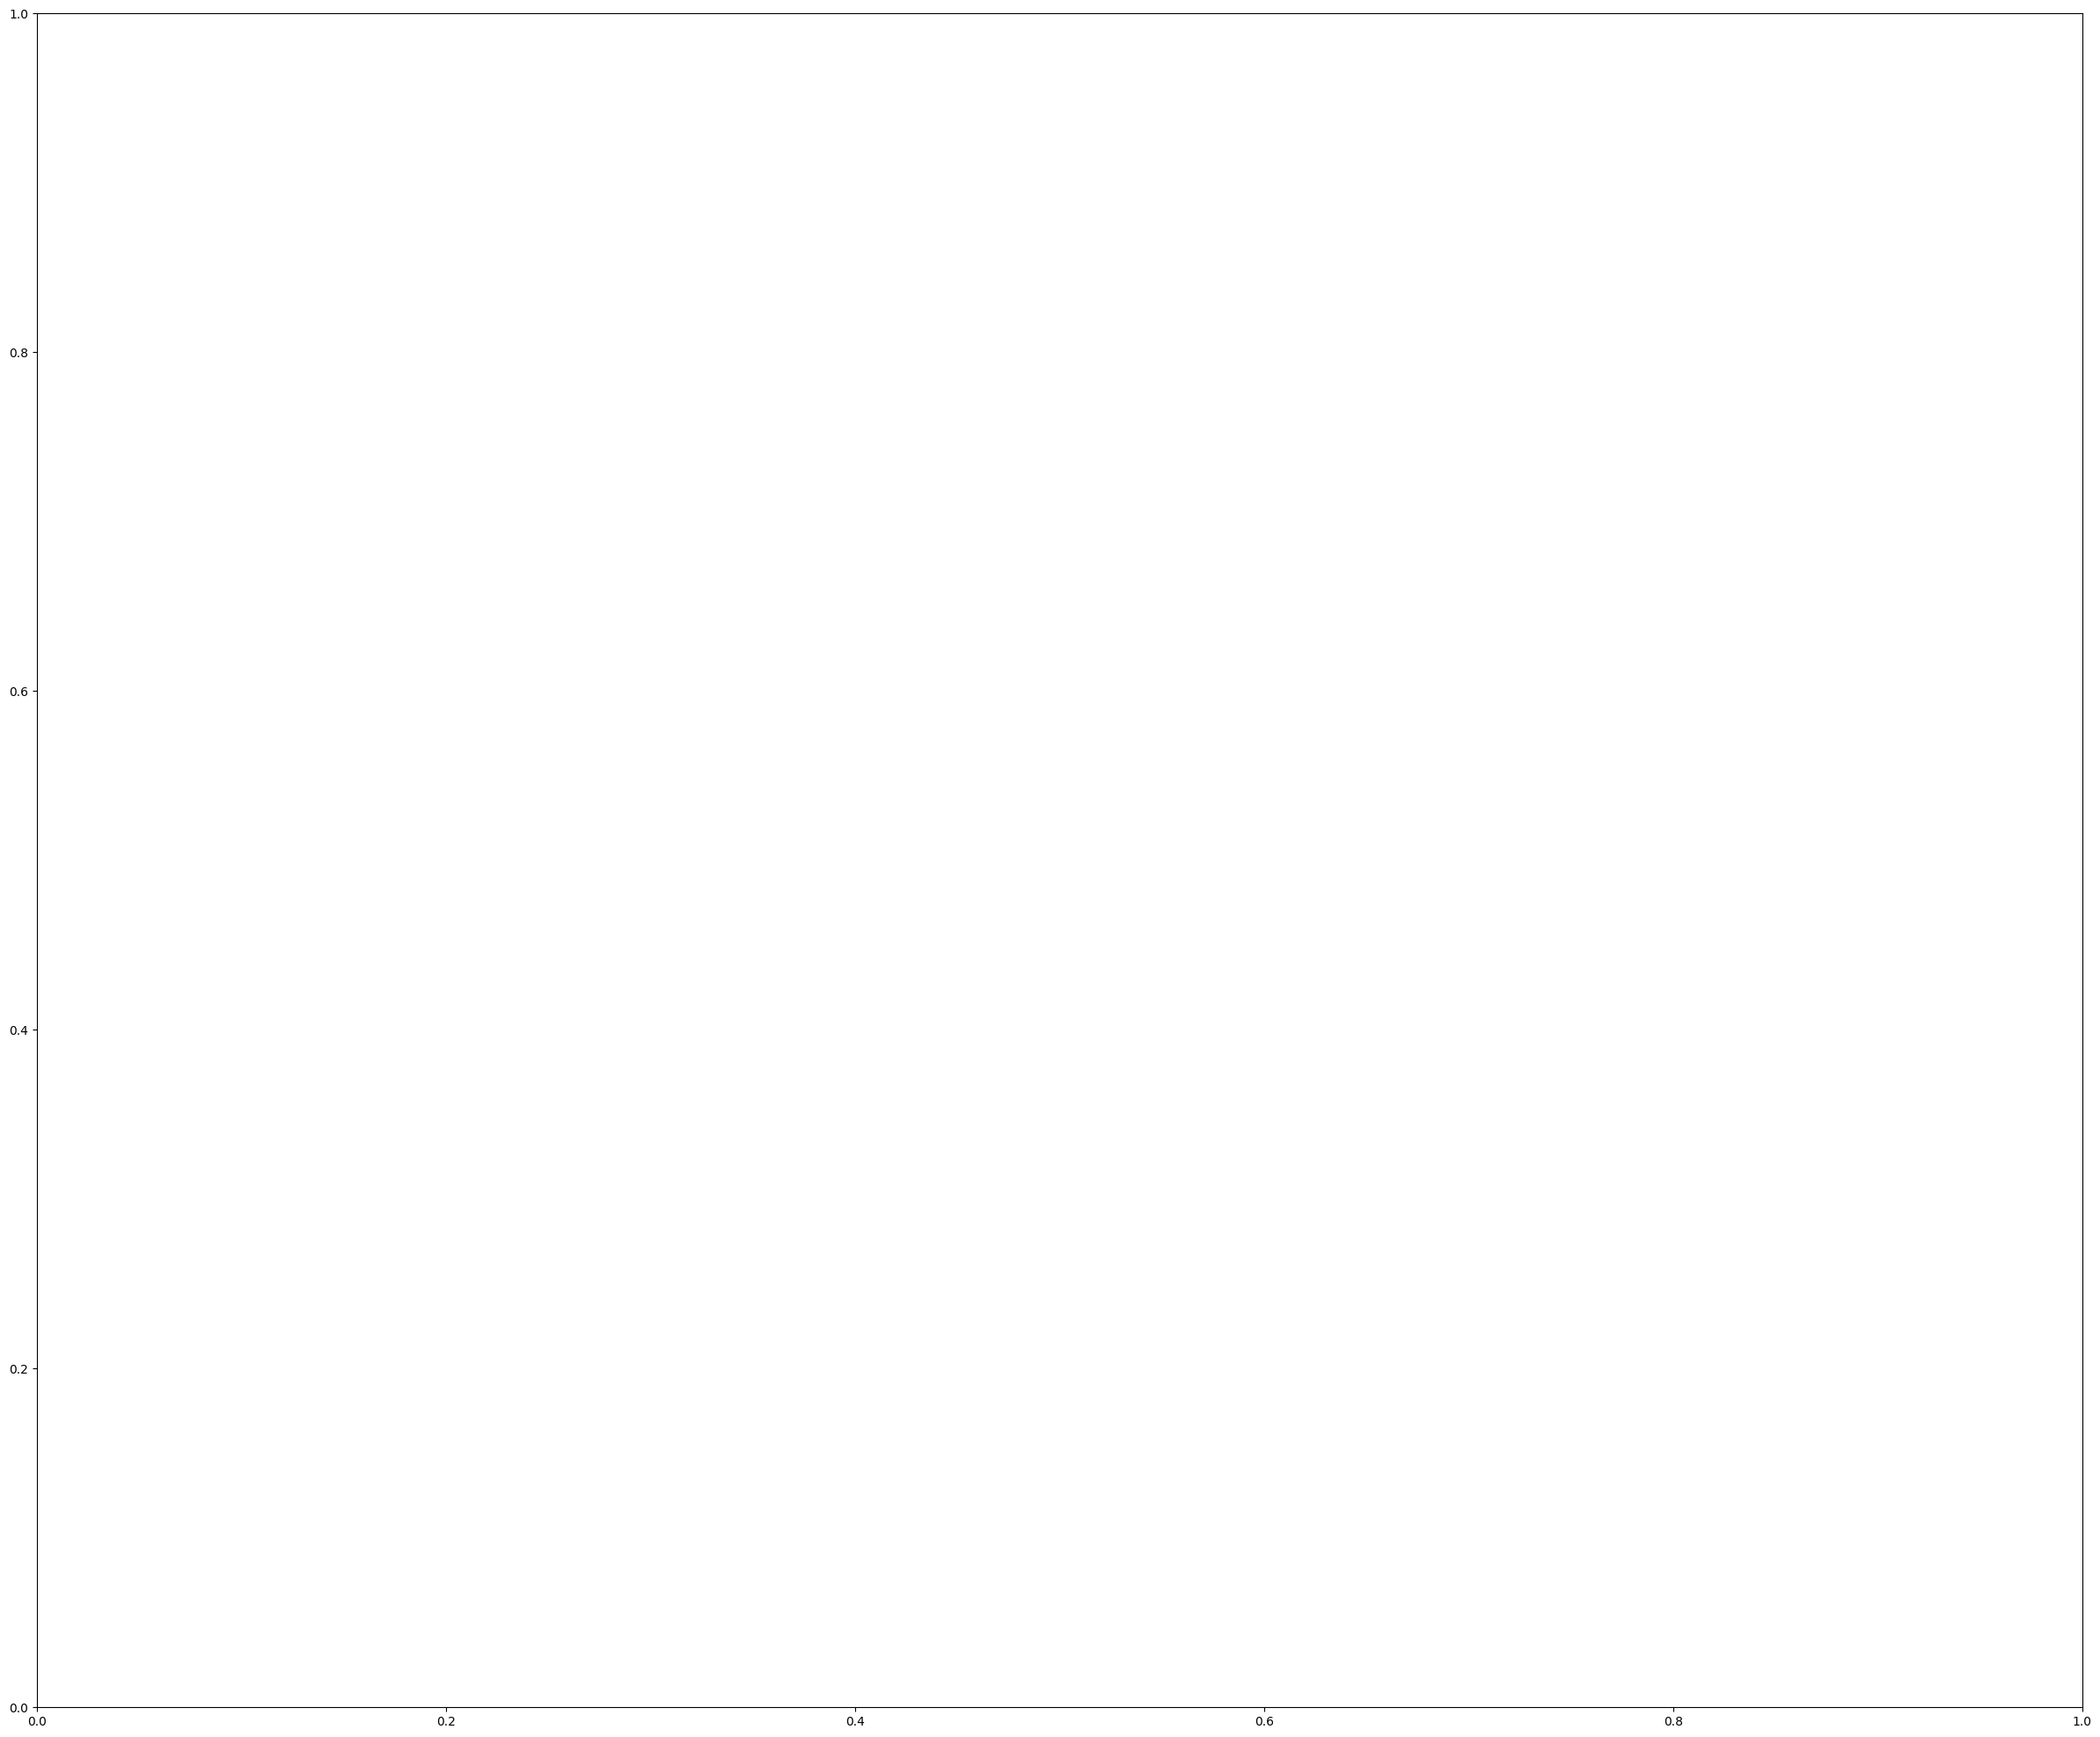

In [430]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 25))

sns.lineplot(
    x= data.query(f"date >= {low_bnd_st} and date <= {up_bnd_st}")["date"],
    y= data.query(f"date >= {low_bnd_st} and date <= {up_bnd_st}")["receipts_count"],
    ax=axes,
    c='red'
)

sns.lineplot(
    x= data.query(f"date < '2016-10-31'")["date"],
    y= data.query(f"date < '2016-10-31'")["receipts_count"],
    ax=axes,
    c='blue'
)

sns.lineplot(
    x= data.query(f"date > '2016-11-10'")["date"],
    y= data.query(f"date > '2016-11-10'")["receipts_count"],
    ax=axes,
    c='blue'
)

plt.show()

---
### ML- подход

#### Начнем с временных рядов

In [351]:
# Тест на стационарность
def adfuller_test(data, column='None'):
    test = adfuller(data[column])
    print("adf: ", test[0])
    print("p-value: ", test[1])
    print("Critical values: ", test[4])

    if (test[0] > test[4]["5%"]):
        print("ряд не стационарен")
    else:
        print("ряд стационарен")

In [352]:
# Немного срежем углы и определим что для дальнейших манипуляций d = 1
adfuller_test(data.diff().dropna(), "receipts_count")

adf:  -6.874263180315063
p-value:  1.4884446590032763e-09
Critical values:  {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}
ряд стационарен


In [353]:
d = 1

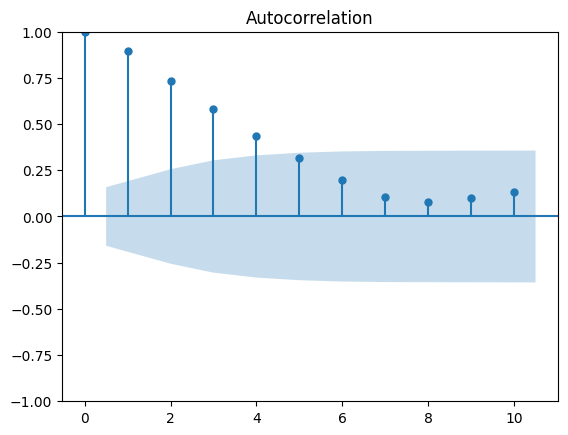

In [354]:
# q = 5
sm.graphics.tsa.plot_acf(data["receipts_count"], lags=10)
plt.show()

In [355]:
q = 5

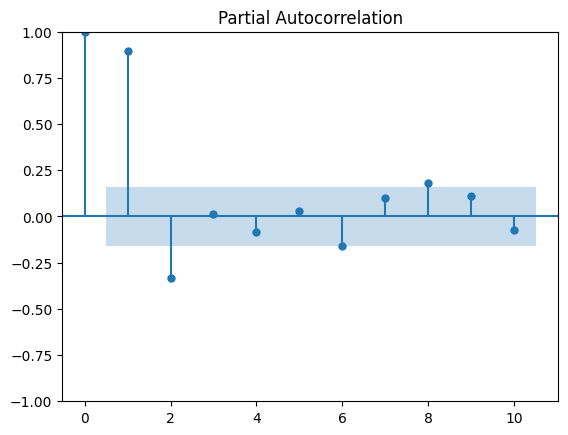

In [356]:
# p = 2
sm.graphics.tsa.plot_pacf(data["receipts_count"], lags=10)
plt.show()

In [357]:
p = 2

----
### Попробуем спрогнозировать моделью ARIMA 

In [358]:
adv_prog_periods = data["date"][data["programm_factor"] == True]
split_list = [i for i in adv_prog_periods]

In [359]:
prognosis_df = pd.DataFrame()

for i in range(len(split_list)):
    try:
        train = data[data["date"] < split_list[i]]
        test = data[(data["date"] >= split_list[i]) & (data["date"] < split_list[i+1])]

        y_train = train.set_index("date")["receipts_count"]
        y_test = test.set_index("date")["receipts_count"]
        
        model = ARIMA(y_train.values.reshape(-1), order=(p,d,q))
        
        arima_predictions = model.fit().predict(
            start=len(y_train),
            end=len(y_train)+len(y_test) -1,  
            dynamic=False)
        
        result = pd.DataFrame(arima_predictions, index=y_test.index, columns=["arima_predictions"])
        
        prognosis_df = pd.concat([prognosis_df, result], axis=0)
    except IndexError:
        pass

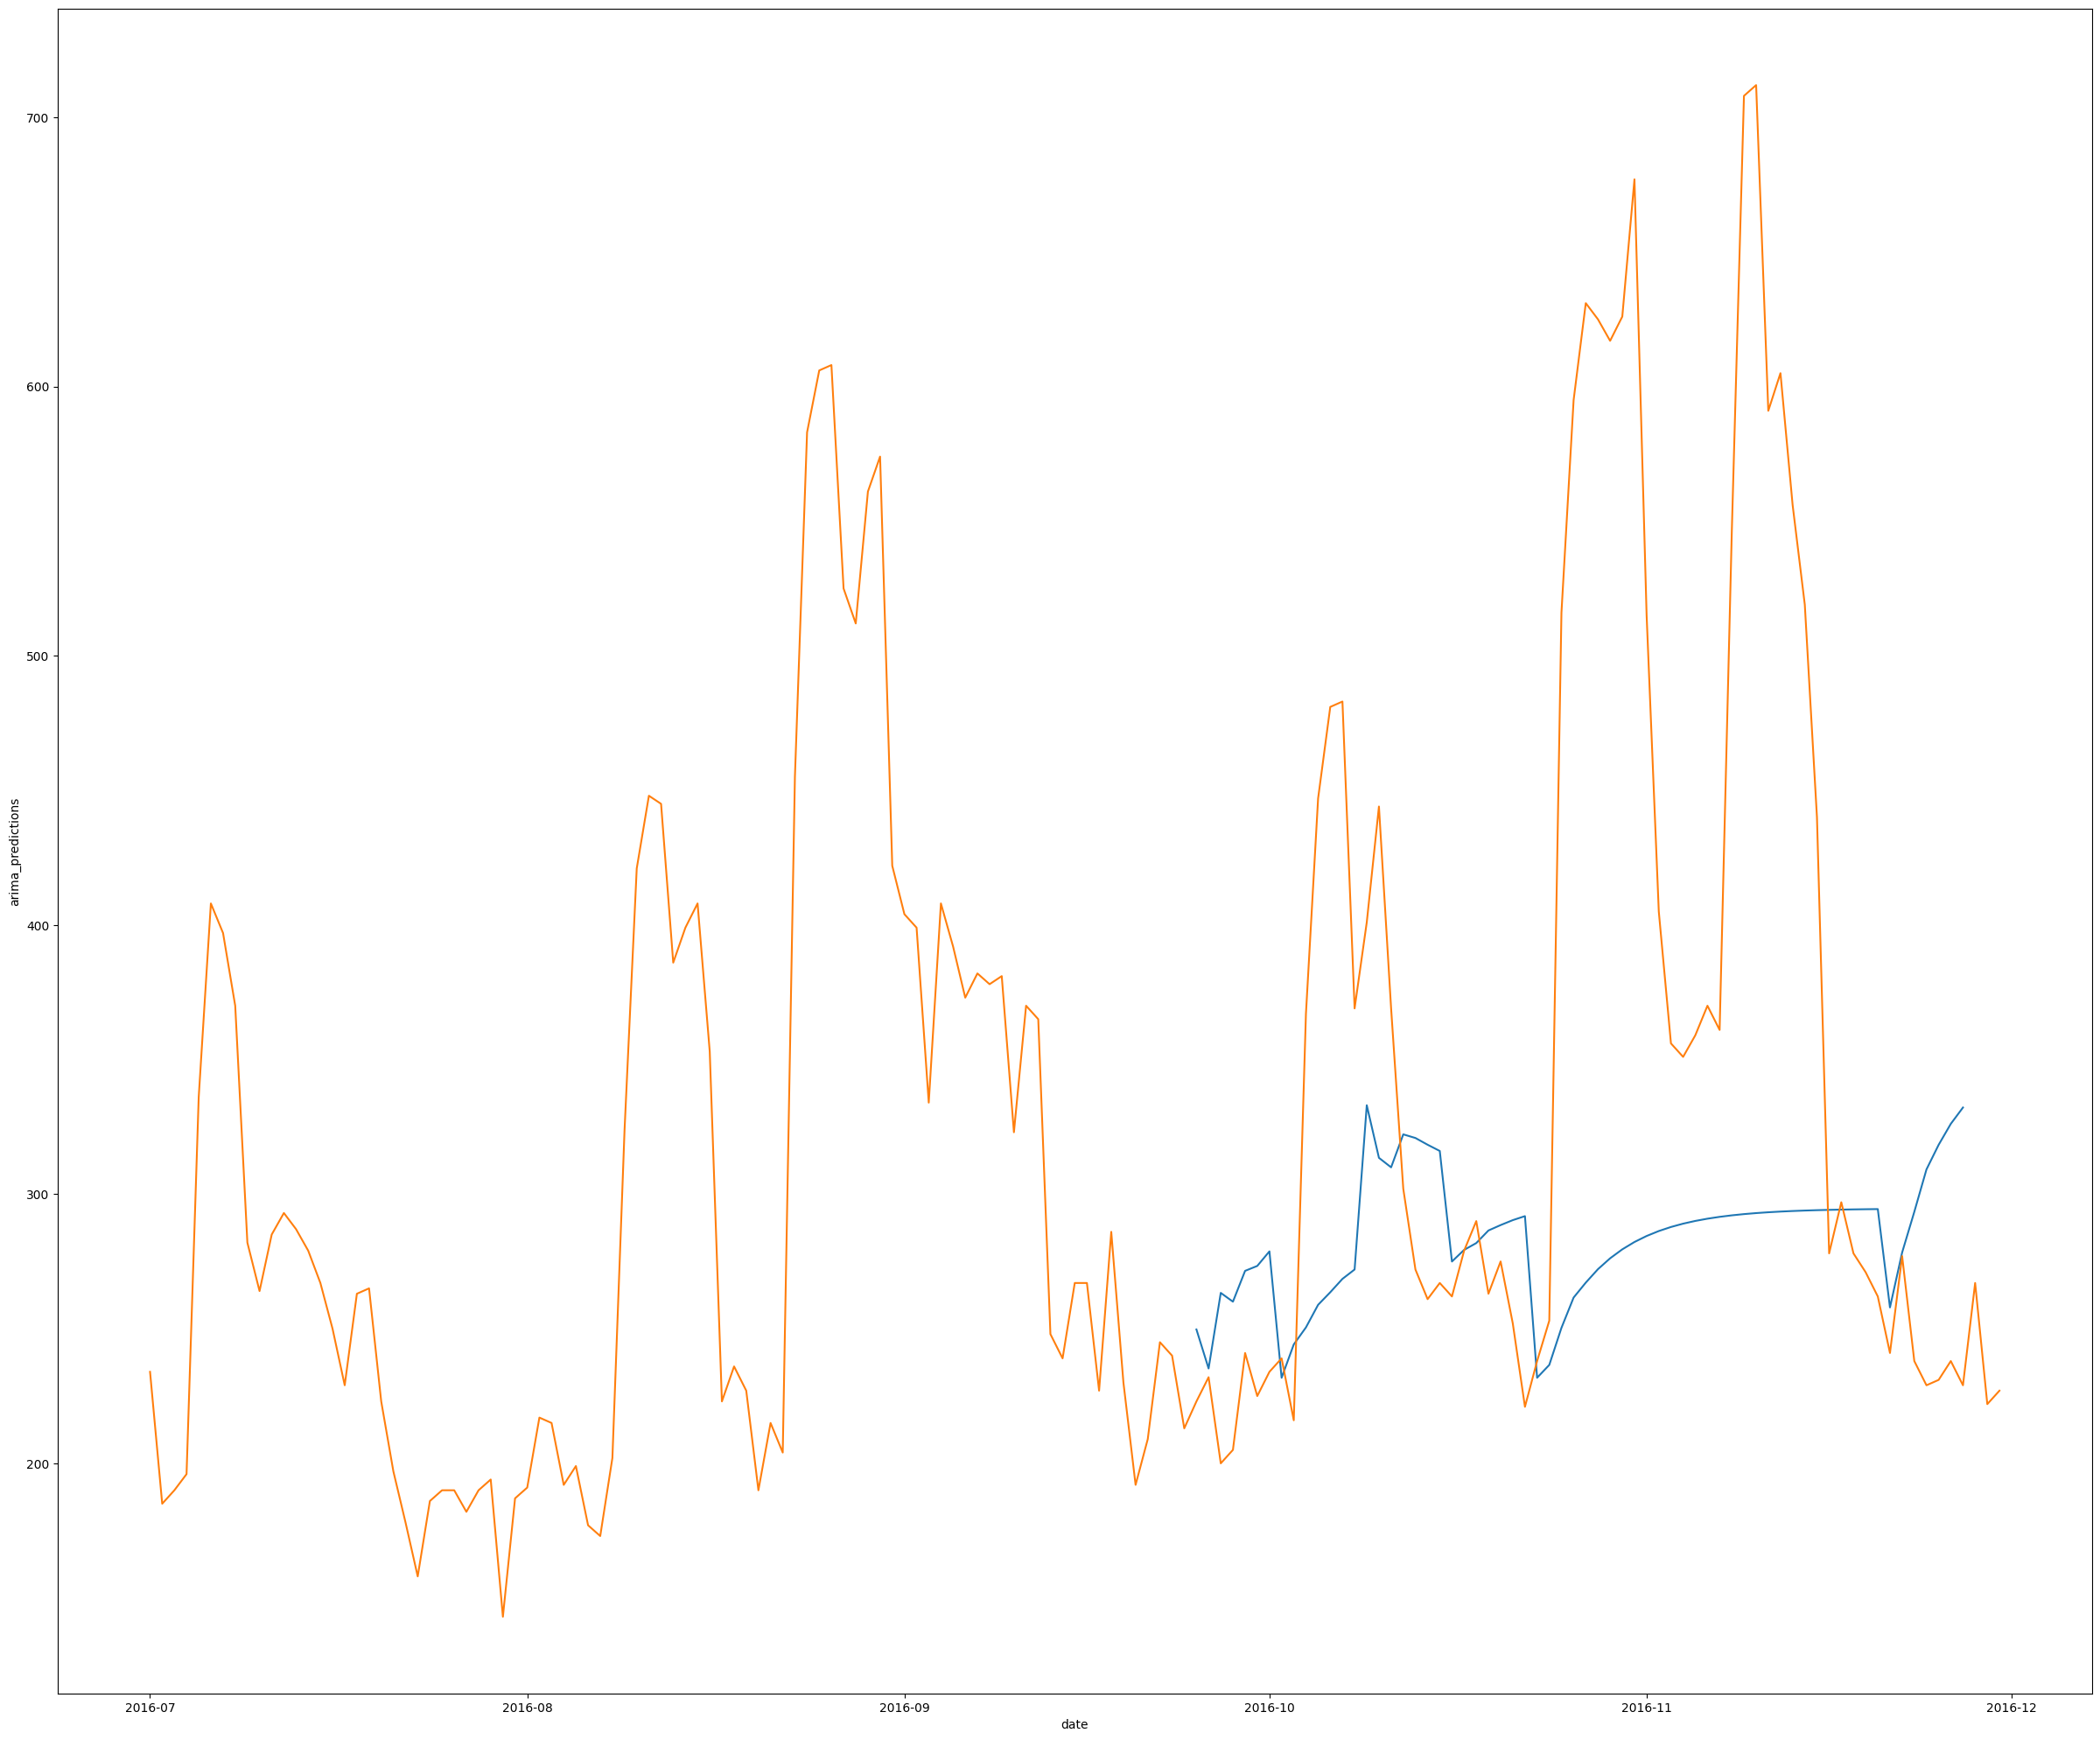

In [360]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 25))

sns.lineplot(data=prognosis_df, x="date", y="arima_predictions", ax=axes)
sns.lineplot(x=data["date"], y=data["receipts_count"], ax=axes)

plt.show()

> Можно отметить интересный факт смещения прогноза и фактических значений- превосходство фактичесхих пиков значительно превосходит прогнозные пики, что может говорить о двух возможных сценариях, либо у нас слабая модель, либо сильное влияние экзогенного фактора (в нашем случае интеграции) не учтенных в модели.

---
### Попробуем спрогнозировать линейной регрессией (есть подозрения, что данных будет не достаточно для корретного прогнозирования линейкой)

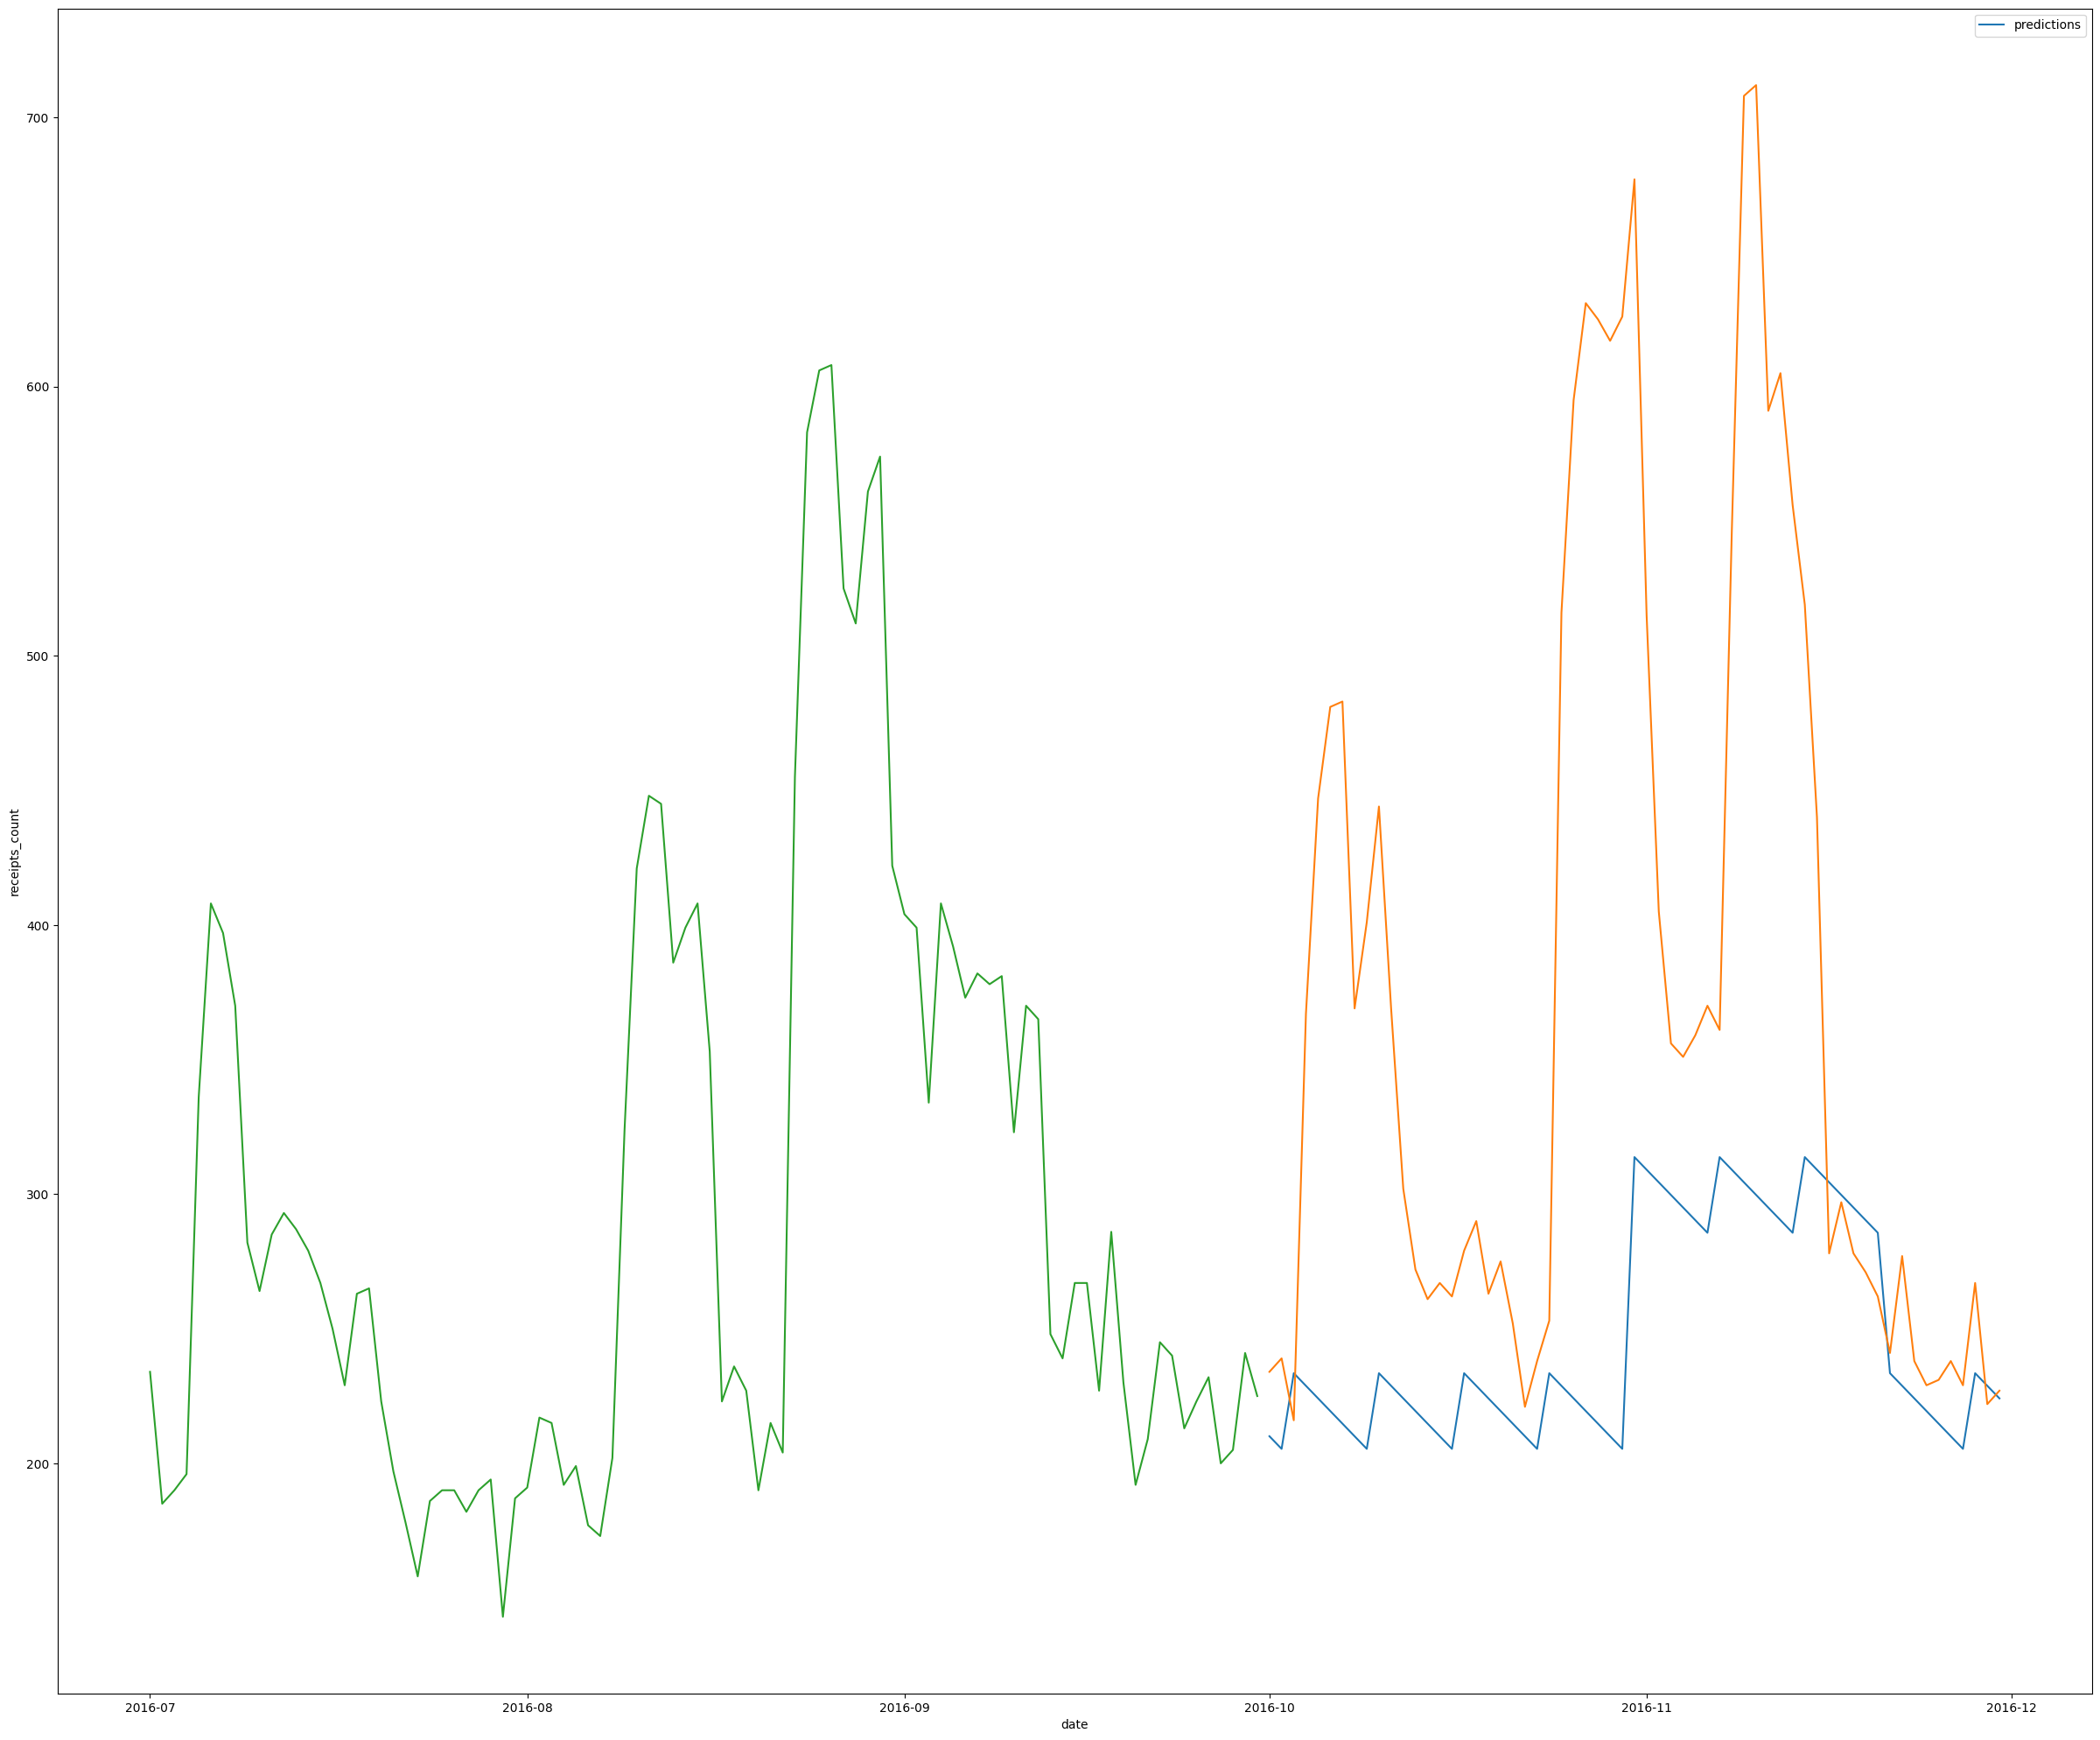

In [361]:
# Для начала рекодируем фактор интеграции, при чем по хитрому, ибо будем интерполировать на 7 дней.
linear_data = data.copy()

linear_data["programm_factor"].replace({True: 1, False: np.nan}, inplace=True)

# Собственно интерполяция
linear_data["programm_factor"].interpolate(method="linear", limit=7, inplace=True)

# Заполнение пропусков
linear_data["programm_factor"].fillna(0, inplace=True)

# Сформируем фичи от даты
linear_data["day_of_week"] = linear_data["date"].dt.dayofweek
# linear_data["month"] = linear_data["date"].dt.month
linear_data["quarter"] = linear_data["date"].dt.quarter
# linear_data["day"] = linear_data["date"].dt.day

# Пробуем спрогнозировать линейной регрессией 
test = linear_data[linear_data["date"].dt.month > 9].set_index("date")
train = linear_data[linear_data["date"].dt.month <= 9].set_index("date")

# Сформируем трейн/тест
test = test[
    ["programm_factor", "day_of_week", "quarter", "receipts_count"]
]

train = train[
    ["programm_factor", "day_of_week", "quarter", "receipts_count"]
]

X_train = train.drop(["receipts_count"], axis=1)
y_train = train["receipts_count"]

X_test = test.drop(["receipts_count"], axis=1)
y_test = test["receipts_count"]

# Начинаем моделировать
model = LinearRegression()

model.fit(X_train, y_train)

prediction = model.predict(X_test)

prediction = pd.DataFrame(prediction, index=y_test.index, columns=["predictions"])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 25))

sns.lineplot(prediction, ax=axes,) 
sns.lineplot(y_test, ax=axes,)
sns.lineplot(y_train, ax=axes,)
axes.legend()
plt.show()


> Модель линейной регрессии смогла смоделировать самый высокий пик в разрезе временного интервала, т.е. она смогла предсказать изменение тренда в период ноября но сильно недооценила масштабы пика, собственно как и модель авторегрессии.